In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
config_df = pd.read_csv("config.csv")
epoch_df = pd.read_csv("epoch.csv")
epoch_df.head()
config_df.head()

,config_id,model_type,model_name,pooling_type,epochs,dropout
0,0,sbert,sentence-transformers/distiluse-base-multiling...,mean,13,0.1
1,1,bert,indobenchmark/indobert-lite-base-p2,cls,24,0.3
2,2,mbert,google-bert/bert-base-multilingual-cased,cls,11,0.1


# Training Plot

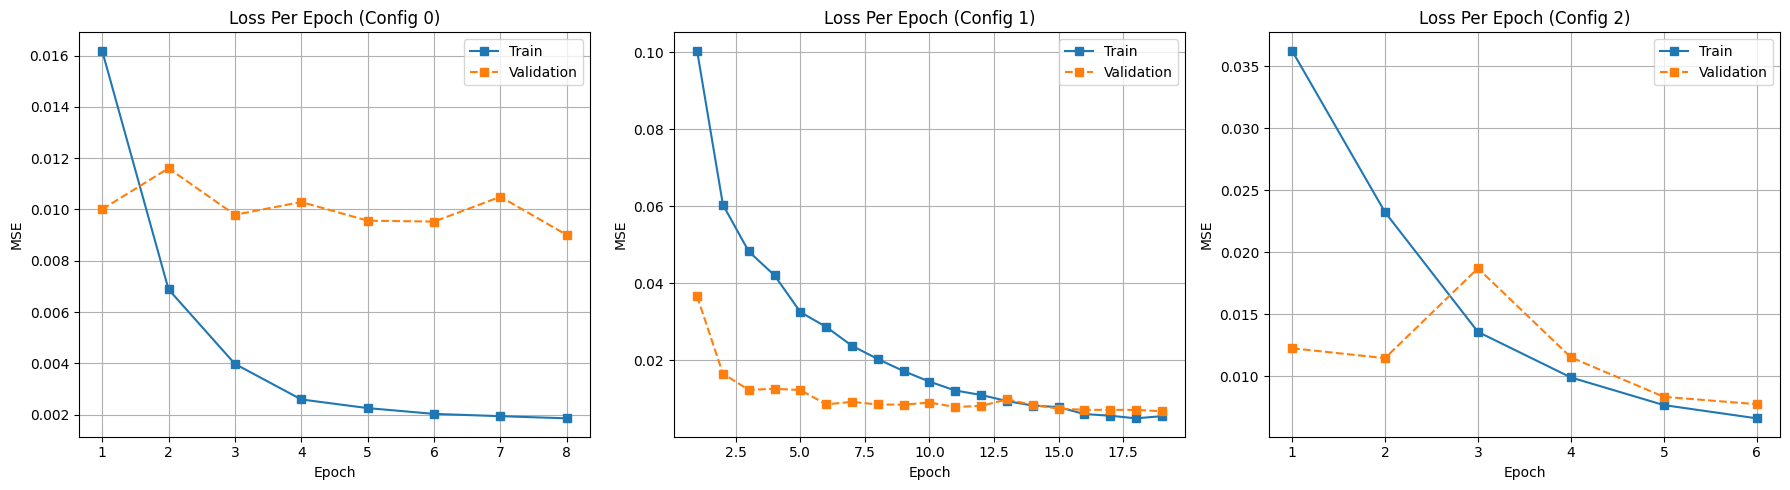

In [28]:
metrics = ['mse']
titles = {
    'mse': 'Loss Per Epoch'
}

fig, axes = plt.subplots(1, 3, figsize=(18, 5)) 

for i, row in enumerate(config_df.itertuples(index=False)):
    
    config_id = row.config_id
    data = epoch_df[epoch_df['config_id'] == config_id]
    
    epochs = data['epoch'].iloc[:-5]
    
    for metric in metrics:
        train_metric = data[f'train_{metric}'].iloc[:-5]
        valid_metric = data[f'valid_{metric}'].iloc[:-5]

        ax = axes[i]
        ax.plot(epochs, train_metric, linestyle='-', marker='s', label='Train')
        ax.plot(epochs, valid_metric, linestyle='--', marker='s', label='Validation')
        
        ax.set_title(f"{titles[metric]} (Config {config_id})")
        ax.set_xlabel("Epoch")
        ax.set_ylabel(metric.upper())
        ax.legend()
        ax.grid(True)

plt.tight_layout()
plt.show()


In [29]:
import sys
import os
src_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..', '..'))
sys.path.append(src_path)
from transformers import BertTokenizer, AutoTokenizer
from main_regression import RegressionModel, AutomaticScoringDataset as AutomaticScoringDatasetBert
from torch.utils.data import DataLoader
import torch
import torch.nn.functional as F
import joblib
from main_similarity import SiameseModel, AutomaticScoringDataset as AutomaticScoringDatasetSBert


def predict_bert(df_test, config_id, model, tokenizer):
    test_data = AutomaticScoringDatasetBert(df_test, tokenizer)
    test_dataloader = DataLoader(test_data, batch_size=16, shuffle=False, generator=torch.Generator().manual_seed(42), num_workers=0)
    
    checkpoint = torch.load(f"../../../models/best_model/spesific/model_{config_id}.pt", map_location='cuda', weights_only=True)
    model.load_state_dict(checkpoint)
    model.eval()
    all_predictions = []
    all_targets = []
    with torch.no_grad():
        for batchs in test_dataloader:
            try:
                # move to device
                batchs = {k: v.to('cuda') for k, v in batchs.items()}
                predictions = model(
                    batchs['input_ids'], 
                    batchs['attention_mask'], 
                    batchs['token_type_ids']).squeeze(1)
                preds = torch.clamp(predictions, 0, 1)

                all_predictions.extend(preds.detach().cpu().numpy())
                all_targets.extend(batchs['labels'].detach().cpu().numpy())
            except Exception as e:
                torch.cuda.empty_cache()

    return all_predictions, all_targets

tokenizerSBert = AutoTokenizer.from_pretrained("sentence-transformers/distiluse-base-multilingual-cased-v2")
def compute_cosine_similarity(dataloader, model):
        all_outputs = []
        all_scores = []
        with torch.no_grad():
            for batchs in dataloader:
                batchs = {
                    k: {kk: vv.to("cuda") for kk, vv in v.items()} if isinstance(v, dict) else v.to("cuda")
                    for k, v in batchs.items()
                }
                
                reference_emb = model(batchs['reference_answer']['input_ids'], batchs['reference_answer']['attention_mask'])
                student_emb = model(batchs['student_answer']['input_ids'], batchs['student_answer']['attention_mask'])
                scores = batchs['labels'].float().view(-1)

                ref_embedding = F.normalize(reference_emb, p=2, dim=1)
                student_embedding = F.normalize(student_emb, p=2, dim=1)

                similarity = F.cosine_similarity(ref_embedding, student_embedding, dim=1)
                similarity = torch.clamp(similarity, -1.0, 1.0)

                all_outputs.append(similarity)
                all_scores.append(scores)

        X = torch.cat(all_outputs, dim=0).cpu().numpy()
        y = torch.cat(all_scores, dim=0).cpu().numpy()

        return X, y

def predict_sbert(df_test, config_id, model):
    test_data = AutomaticScoringDatasetSBert(df_test, tokenizerSBert)
    test_dataloader = DataLoader(test_data, batch_size=16, shuffle=False, generator=torch.Generator().manual_seed(42), num_workers=0)
    
    
    checkpoint = torch.load(f"../../../models/best_model/spesific/model_{config_id}.pt", map_location='cuda', weights_only=True)
    reg_model = joblib.load(f"../../../models/best_model/spesific/reg_{config_id}.pkl")
    model.load_state_dict(checkpoint)
    model.eval()
    X_test, y_test = compute_cosine_similarity(test_dataloader, model)
    y_test_pred = reg_model.predict(X_test.reshape(-1, 1))

    return X_test, y_test_pred, y_test

def save_predictions(df_test, output_path):
    columns_to_keep = ['question', 'reference_answer', 'answer', 'normalized_score', 'dataset_num']
    columns_to_keep += [col for col in df_test.columns if col.startswith("predicted_score_")]
    df_test = df_test[columns_to_keep]
    df_test.to_csv(output_path, index=False)

In [30]:
import pandas as pd

df_test = pd.read_csv("../../../../data/clean/spesific/test_indo.csv")
for row in config_df.itertuples():
    if row.model_type == "bert" or row.model_type == 'mbert':
        tokenizer = BertTokenizer.from_pretrained(row.model_name)
        model = RegressionModel(row.model_name, pooling_type=row.pooling_type).to('cuda')
        all_predictions, all_targets = predict_bert(df_test, row.config_id, model, tokenizer)
    else:
        model = SiameseModel("sentence-transformers/distiluse-base-multilingual-cased-v2", pooling_type=row.pooling_type).to('cuda')
        similarity, all_predictions, all_targets = predict_sbert(df_test, row.config_id, model)
        df_test[f'similarity_{row.config_id}'] = similarity

    df_test[f"predicted_score_{row.config_id}"] = all_predictions

output_dir = "inference"
os.makedirs(output_dir, exist_ok=True)

df_test.to_csv(os.path.join(output_dir, "result.csv"), index=False)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'AlbertTokenizer'. 
The class this function is called from is 'BertTokenizer'.
Some weights of the model checkpoint at indobenchmark/indobert-lite-base-p2 were not used when initializing AlbertModel: ['pooler.bias', 'pooler.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



>> Similarity-Based Scoring
RMSE: 0.0996, Pearson: 0.9285

>> Direct Scoring (IndoBERT)
RMSE: 0.0817, Pearson: 0.9504

>> Direct Scoring (mBERT)
RMSE: 0.0847, Pearson: 0.9478


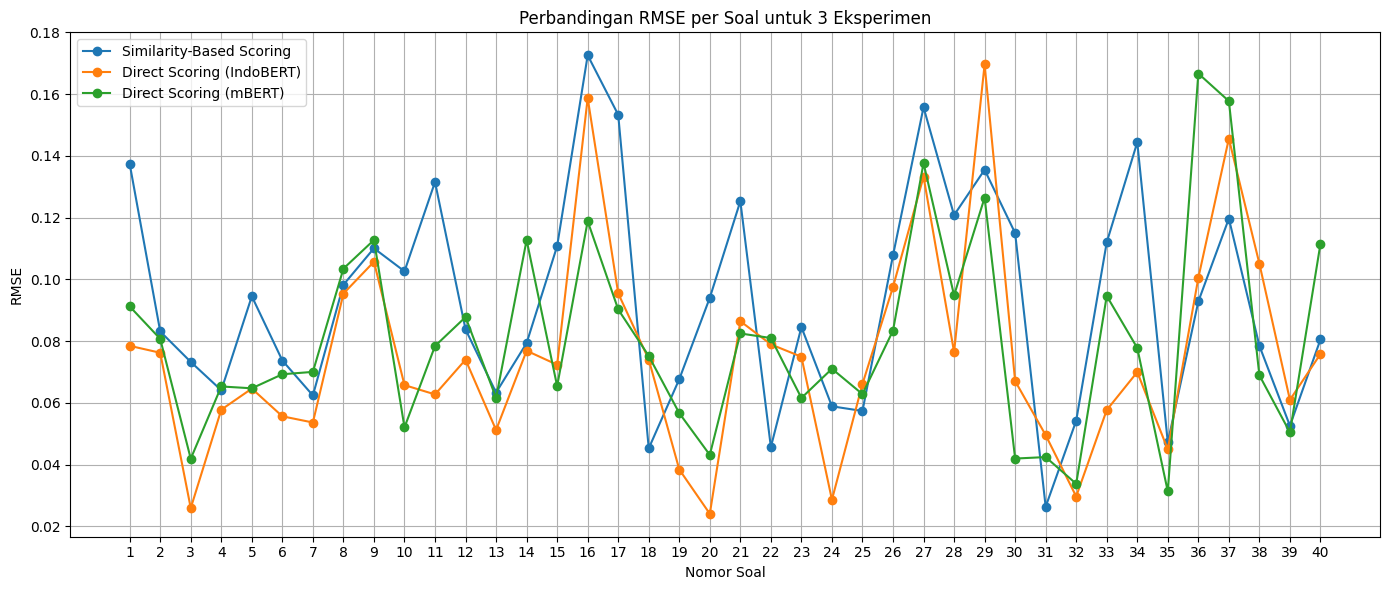

{
    "Similarity-Based Scoring": {
        "1": 0.13740957827979475,
        "2": 0.08311885217257552,
        "3": 0.07325951789445495,
        "4": 0.06408048156068652,
        "5": 0.09451850813159639,
        "6": 0.07371350011638077,
        "7": 0.06239205887655208,
        "8": 0.09825148865801127,
        "9": 0.11007437699503898,
        "10": 0.10262088414802126,
        "11": 0.13155643828312286,
        "12": 0.08378753237373714,
        "13": 0.0633280599961398,
        "14": 0.0793696788415193,
        "15": 0.11079576720649656,
        "16": 0.17261515514228298,
        "17": 0.15332311584377928,
        "18": 0.045247349399696685,
        "19": 0.06766615489706261,
        "20": 0.09404938232674631,
        "21": 0.1253365200027106,
        "22": 0.04566469649401801,
        "23": 0.08454936194140189,
        "24": 0.05887633565829858,
        "25": 0.05736065768223288,
        "26": 0.10777727932533106,
        "27": 0.15576782274490908,
        "28": 0.12081300031102

In [31]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error
from scipy.stats import pearsonr
from tabulate import tabulate
import json

inference_dir = "inference"
csv_files = [f for f in os.listdir(inference_dir) if f.endswith(".csv")]

color_palette = plt.get_cmap("tab10") 

label_map = {
    "predicted_score_0": "Similarity-Based Scoring",
    "predicted_score_1": "Direct Scoring (IndoBERT)",
    "predicted_score_2": "Direct Scoring (mBERT)",
}

rmse_per_model = {}
metric_eval_data = {}
model_idx = 0
for file in csv_files:
    file_path = os.path.join(inference_dir, file)
    df = pd.read_csv(file_path)

    true_scores = df['normalized_score'].values
    pred_cols = [col for col in df.columns if col.startswith("predicted_score_")]

    for col in pred_cols:
        pred_scores = df[col].values
        residuals = pred_scores - true_scores

        rmse = root_mean_squared_error(true_scores, pred_scores)
        pearson, _ = pearsonr(true_scores, pred_scores)

        label = label_map.get(col, col)
        print(f"\n>> {label}")
        print(f"RMSE: {rmse:.4f}, Pearson: {pearson:.4f}")

        metric_eval_data[label] = {
            "RMSE": round(rmse, 4),
            "Pearson": round(pearson, 4)
        }

        rmse_per_soal = df.groupby('dataset_num').apply(lambda x: root_mean_squared_error(x['normalized_score'], x[col]), include_groups=False)
        rmse_per_model[label] = rmse_per_soal
        model_idx += 1

def extract_soal_number(index_series):
    return index_series.astype(str).str.extract(r'(\d+)$').astype(int)[0]

plt.figure(figsize=(14, 6))
rmse_json = {}
for i, label in enumerate(rmse_per_model):
    rmse_series = rmse_per_model[label]
    
    soal_numbers = extract_soal_number(rmse_series.index)
    
    rmse_series.index = soal_numbers
    rmse_series = rmse_series.sort_index()
    
    plt.plot(rmse_series.index, rmse_series.values, marker='o', linestyle='-', label=label)
    rmse_json[label] = {
        str(soal): float(rmse) for soal, rmse in rmse_series.items()
    }

plt.title("Perbandingan RMSE per Soal untuk 3 Eksperimen")
plt.xlabel("Nomor Soal")
plt.ylabel("RMSE")
plt.grid(True)
plt.legend()
plt.xticks(ticks=sorted(rmse_series.index.unique())) 
plt.tight_layout()
plt.show()

print(json.dumps(rmse_json, indent=4))

In [32]:
import os
import numpy as np
import pandas as pd

thresholds = [0.1, 0.2]
model_data = []

for file in csv_files:
    df = pd.read_csv(os.path.join(inference_dir, file))
    true_scores = df['normalized_score'].values
    pred_cols = [c for c in df.columns if c.startswith("predicted_score_")]

    for col in pred_cols:
        pred_scores = df[col].values

        abs_residuals = np.abs(pred_scores - true_scores)

        q1 = np.percentile(abs_residuals, 25)
        q3 = np.percentile(abs_residuals, 75)
        iqr = q3 - q1
        upper_bound = q3 + 1.5 * iqr

        outlier_iqr_mask = abs_residuals > upper_bound
        num_outliers_iqr = np.sum(outlier_iqr_mask)

        label = label_map.get(col, col)
        model_data.append({
            "label": label,
            "q1": q1,
            "q3": q3,
            "upper_bound": upper_bound,
            "num_outliers_iqr": num_outliers_iqr,
            "abs_residuals": abs_residuals
        })

outlier_count = {}
for model in sorted(model_data, key=lambda x: x["label"]):
    label = model["label"]
    abs_residuals = model["abs_residuals"]

    print(f"{label}:")
    print(f"  Q1       : {model['q1']:.4f}")
    print(f"  Q3       : {model['q3']:.4f}")
    print(f"  Upper bd : {model['upper_bound']:.4f}")
    print(f"  Outlier (IQR)       : {model['num_outliers_iqr']}")

    outlier_summary = {
        "IQR": model['num_outliers_iqr']
    }

    for t in thresholds:
        num_out = np.sum(abs_residuals > t)
        outlier_summary[f"Fixed {t}"] = num_out
        print(f"  Outlier (Fixed {t}) : {num_out}")

    print()
    outlier_count[label] = outlier_summary


Direct Scoring (IndoBERT):
  Q1       : 0.0159
  Q3       : 0.0839
  Upper bd : 0.1859
  Outlier (IQR)       : 7
  Outlier (Fixed 0.1) : 42
  Outlier (Fixed 0.2) : 4

Direct Scoring (mBERT):
  Q1       : 0.0258
  Q3       : 0.0878
  Upper bd : 0.1807
  Outlier (IQR)       : 10
  Outlier (Fixed 0.1) : 44
  Outlier (Fixed 0.2) : 9

Similarity-Based Scoring:
  Q1       : 0.0268
  Q3       : 0.0917
  Upper bd : 0.1889
  Outlier (IQR)       : 17
  Outlier (Fixed 0.1) : 50
  Outlier (Fixed 0.2) : 16



C:\Users\User\AppData\Local\Temp\ipykernel_13032\2566432802.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(residuals_list, labels=labels, patch_artist=True, showfliers=True)


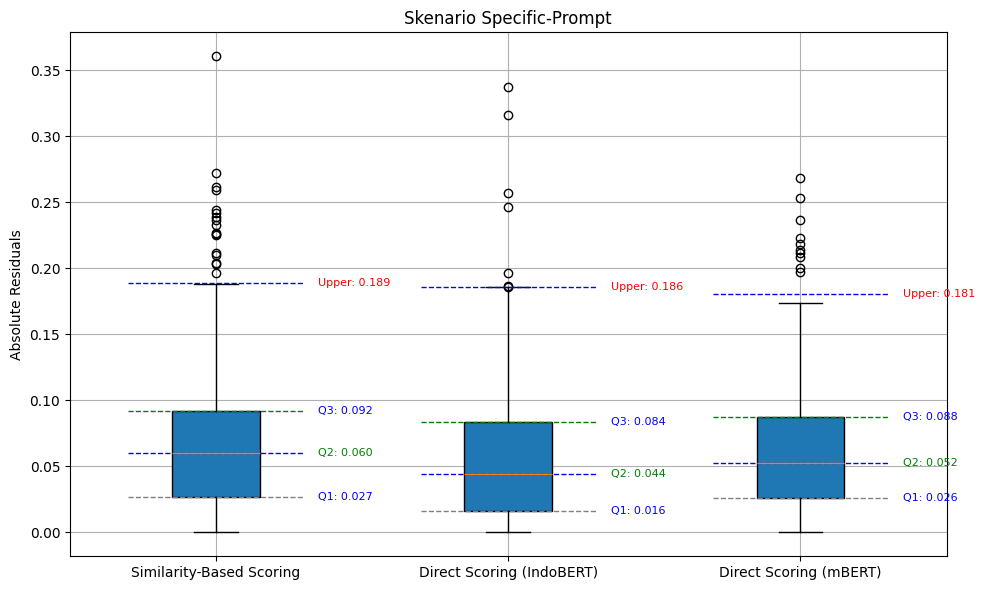

In [33]:
import matplotlib.pyplot as plt

residuals_list = [model["abs_residuals"] for model in model_data]
labels = [model["label"] for model in model_data]

fig, ax = plt.subplots(figsize=(10, 6))
box = ax.boxplot(residuals_list, labels=labels, patch_artist=True, showfliers=True)

for i, model in enumerate(model_data):
    q1 = model['q1']
    q3 = model['q3']
    iqr = q3 - q1
    median = np.median(model['abs_residuals'])
    upper_bound = q3 + 1.5 * iqr

    xpos = i + 1
    
    ax.hlines([q1, median, q3, upper_bound], 
              xmin=xpos - 0.3, xmax=xpos + 0.3, 
              colors=["gray", "blue", "green", "blue", "red"], 
              linestyles='--', linewidth=1)

    ax.text(xpos + 0.35, q1, f"Q1: {q1:.3f}", va='center', fontsize=8, color='blue')
    ax.text(xpos + 0.35, median, f"Q2: {median:.3f}", va='center', fontsize=8, color='green')
    ax.text(xpos + 0.35, q3, f"Q3: {q3:.3f}", va='center', fontsize=8, color='blue')
    ax.text(xpos + 0.35, upper_bound, f"Upper: {upper_bound:.3f}", va='center', fontsize=8, color='red')

ax.set_ylabel("Absolute Residuals")
ax.set_title("Skenario Specific-Prompt")
ax.grid(True)
plt.tight_layout()
plt.show()


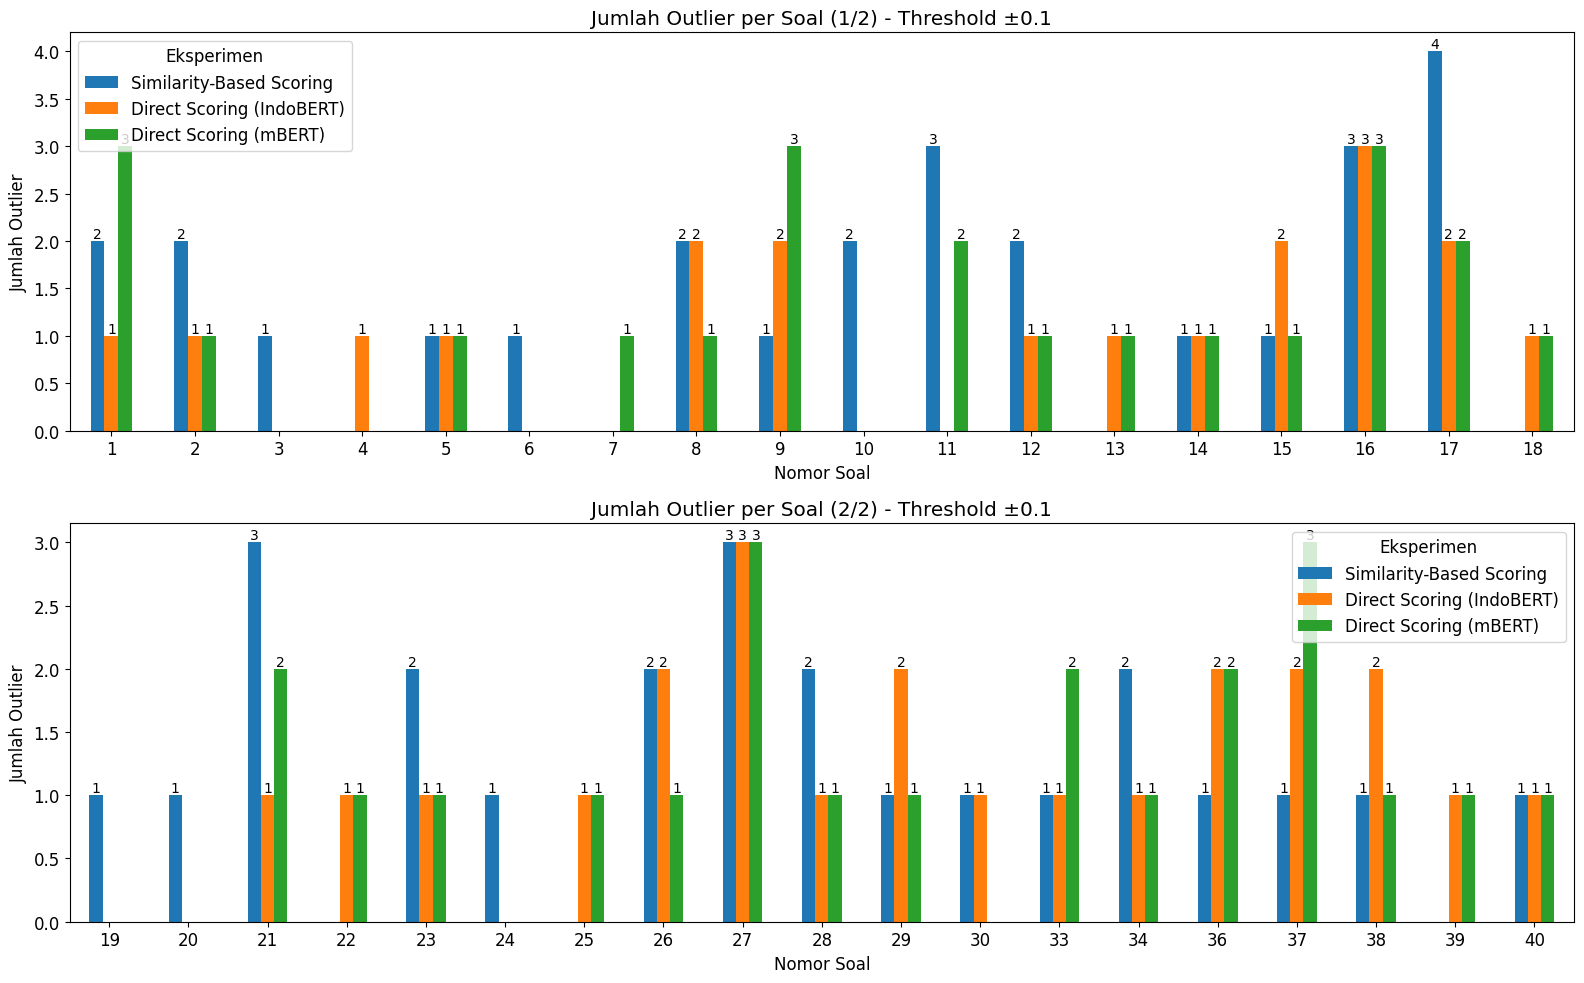

In [34]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

outlier_counts_fixed2 = {}
outlier_counts_fixed1 = {}

fixed_threshold2 = 0.2
fixed_threshold1 = 0.1

for file in csv_files:
    df = pd.read_csv(os.path.join(inference_dir, file))
    true_scores = df['normalized_score'].values
    pred_cols = [col for col in df.columns if col.startswith("predicted_score_")]
    df['soal_num'] = df['dataset_num'].str.extract(r'-(\d+)$').astype(int)

    for col in pred_cols:
        residuals = df[col].values - true_scores

        outlier_mask_fixed2 = np.abs(residuals) > fixed_threshold2
        outlier_mask_fixed1 = np.abs(residuals) > fixed_threshold1

        df['outlier_fixed2'] = outlier_mask_fixed2
        df['outlier_fixed1'] = outlier_mask_fixed1

        label = label_map.get(col, col)

        fixed_counts2 = df[df['outlier_fixed2']].groupby('soal_num').size()
        outlier_counts_fixed2[label] = fixed_counts2

        fixed_counts1 = df[df['outlier_fixed1']].groupby('soal_num').size()
        outlier_counts_fixed1[label] = fixed_counts1

df_fixed2 = pd.DataFrame(outlier_counts_fixed2).fillna(0).astype(int).sort_index()
df_fixed1 = pd.DataFrame(outlier_counts_fixed1).fillna(0).astype(int).sort_index()

import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 12})

soal_nums = df_fixed1.index
midpoint = len(soal_nums) // 2
first_half = soal_nums[:midpoint]
second_half = soal_nums[midpoint:]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10)) 

df_fixed1.loc[first_half].plot(kind='bar', ax=ax1)
ax1.set_title("Jumlah Outlier per Soal (1/2) - Threshold ±0.1")
ax1.set_xlabel("Nomor Soal")
ax1.set_ylabel("Jumlah Outlier")
ax1.legend(title="Eksperimen", fontsize=12, title_fontsize=12)
ax1.tick_params(axis='x', rotation=0, labelsize=12)

for container in ax1.containers:
    for bar in container:
        height = bar.get_height()
        if height > 0:
            ax1.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}',
                     ha='center', va='bottom', fontsize=10)

df_fixed1.loc[second_half].plot(kind='bar', ax=ax2)
ax2.set_title("Jumlah Outlier per Soal (2/2) - Threshold ±0.1")
ax2.set_xlabel("Nomor Soal")
ax2.set_ylabel("Jumlah Outlier")
ax2.legend(title="Eksperimen", fontsize=12, title_fontsize=12)
ax2.tick_params(axis='x', rotation=0, labelsize=12)

for container in ax2.containers:
    for bar in container:
        height = bar.get_height()
        if height > 0:
            ax2.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}',
                     ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

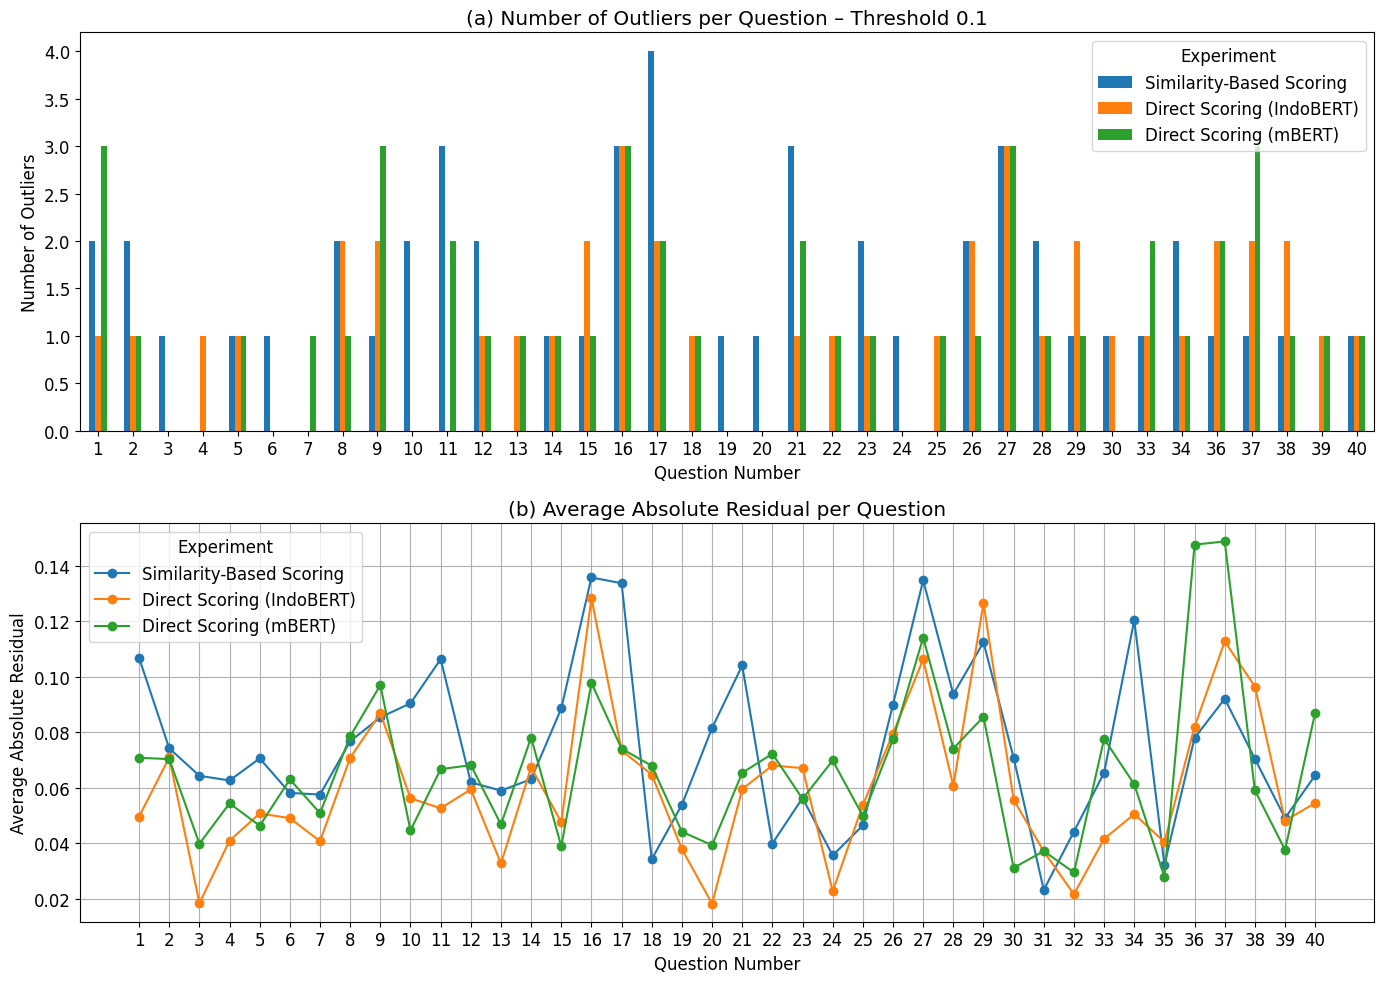

In [35]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

outlier_counts_fixed1 = {}
fixed_threshold1 = 0.1

for file in csv_files:
    df = pd.read_csv(os.path.join(inference_dir, file))
    true_scores = df['normalized_score'].values
    pred_cols = [col for col in df.columns if col.startswith("predicted_score_")]
    df['soal_num'] = df['dataset_num'].str.extract(r'-(\d+)$').astype(int)

    for col in pred_cols:
        residuals = df[col].values - true_scores
        df['outlier_fixed1'] = np.abs(residuals) > fixed_threshold1
        label = label_map.get(col, col)
        fixed_counts1 = df[df['outlier_fixed1']].groupby('soal_num').size()
        outlier_counts_fixed1[label] = fixed_counts1

df_fixed1 = pd.DataFrame(outlier_counts_fixed1).fillna(0).astype(int).sort_index()

absolute_residual_per_model = {}
metric_eval_data = {}

for file in csv_files:
    df = pd.read_csv(os.path.join(inference_dir, file))
    true_scores = df['normalized_score'].values
    pred_cols = [col for col in df.columns if col.startswith("predicted_score_")]

    for col in pred_cols:
        pred_scores = df[col].values
        residuals = np.abs(pred_scores - true_scores)
        pearson, _ = pearsonr(true_scores, pred_scores)
        label = label_map.get(col, col)

        metric_eval_data[label] = {"Pearson": round(pearson, 4)}
        avg_abs_resid = df.groupby('dataset_num').apply(
            lambda x: np.mean(np.abs(x[col] - x['normalized_score'])),
            include_groups=False
        )
        absolute_residual_per_model[label] = avg_abs_resid

def extract_soal_number(index_series):
    return index_series.astype(str).str.extract(r'(\d+)$').astype(int)[0]

plt.rcParams.update({'font.size': 12})
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))  

df_fixed1.plot(kind='bar', ax=ax1)
ax1.set_title("(a) Number of Outliers per Question – Threshold 0.1")
ax1.set_xlabel("Question Number")
ax1.set_ylabel("Number of Outliers")
ax1.legend(title="Experiment", fontsize=12, title_fontsize=12)
ax1.tick_params(axis='x', rotation=0)

absolute_residual_json = {}
for label, series in absolute_residual_per_model.items():
    soal_numbers = extract_soal_number(series.index)
    series.index = soal_numbers
    series = series.sort_index()
    ax2.plot(series.index, series.values, marker='o', linestyle='-', label=label)
    absolute_residual_json[label] = {
        str(soal): float(residual) for soal, residual in series.items()
    }

ax2.set_title("(b) Average Absolute Residual per Question")
ax2.set_xlabel("Question Number")
ax2.set_ylabel("Average Absolute Residual")
ax2.grid(True)
ax2.legend(title="Experiment", fontsize=12, title_fontsize=12)
ax2.set_xticks(sorted(series.index.unique()))

plt.tight_layout()
plt.show()

In [36]:
import json

interesting_num = [16, 27]
for file in csv_files:
    df = pd.read_csv(os.path.join(inference_dir, file))
    true_scores = df['normalized_score'].values
    pred_cols = [col for col in df.columns if col.startswith("predicted_score_")]
    df['soal_num'] = df['dataset_num'].str.extract(r'-(\d+)$').astype(int)

    for col in pred_cols:
        residuals = df[col].values - true_scores
        outlier_mask = np.abs(residuals) > fixed_threshold1

        subset_iqr = df[outlier_mask][['soal_num', 'question', 'reference_answer', 'answer', 'normalized_score', col]].copy()
        subset_iqr = subset_iqr[subset_iqr['soal_num'].isin(interesting_num)]
        if not subset_iqr.empty:
            print(f"\nIQR Outliers untuk eksperimen: {label_map.get(col, col)}")
            print(subset_iqr.to_json(orient="records", indent=2, force_ascii=False))



IQR Outliers untuk eksperimen: Similarity-Based Scoring
[
  {
    "soal_num":16,
    "question":"Apa yang anda ketahui mengenai Cristiano Ronaldo? (lahir, kebangsaan, klub saat ini, klub sebelum, nomor punggung dan sebutannya) ",
    "reference_answer":"cristiano ronaldo lahir di portugal 5 februari 1985 cristiano ronaldo dapat berposisi sebagai sayap kiri atau kanan serta penyerang tengah saat ini ia bermain untuk tim spanyol real madrid dan untuk tim nasional portugal sebelunya ia pernah bermain di sporting lisboa dan manchester united cristiano ronaldo kerap bernomor punggung 7 hingga mendapat sebutanan cr7",
    "answer":"lahir di santo antonio portugal 5 februari 1985 saat ini berada di klub real madrid dan klub sebelumnya adalah manchester united pada saat di mu bernomor punggung 7 dan di real madrid 7",
    "normalized_score":0.73,
    "predicted_score_0":0.5777681
  },
  {
    "soal_num":16,
    "question":"Apa yang anda ketahui mengenai Cristiano Ronaldo? (lahir, kebangsaan, 

# Best On Both

In [37]:
import json

interesting_num = [7, 31, 32]
for file in csv_files:
    df = pd.read_csv(os.path.join(inference_dir, file))
    true_scores = df['normalized_score'].values
    pred_cols = [col for col in df.columns if col.startswith("predicted_score_")]
    df.loc[:,'soal_num'] = df['dataset_num'].str.extract(r'-(\d+)$').astype(int)


    subset_iqr = df[['soal_num', 'question', 'reference_answer', 'answer', 'normalized_score', 'predicted_score_0', 'predicted_score_1']].copy()
    subset_iqr.loc[:, 'residual_similarity'] = subset_iqr.apply(lambda x: abs(x['predicted_score_0'] - x['normalized_score']), axis=1)
    subset_iqr.loc[:, 'residual_direct'] = subset_iqr.apply(lambda x: abs(x['predicted_score_1'] - x['normalized_score']), axis=1)
    subset_iqr.rename(columns={"predicted_score_0": "predicted_score_similarity", "predicted_score_1": "predicted_score_direct"}, inplace=True)
    subset_iqr = subset_iqr[['soal_num', 'question', 'reference_answer', 'answer', 'normalized_score', 'predicted_score_similarity', 'residual_similarity','predicted_score_direct', 'residual_direct']]
    subset_iqr = subset_iqr[subset_iqr['soal_num'].isin(interesting_num)]
    print(subset_iqr.to_json(orient="records", indent=2, force_ascii=False))


[
  {
    "soal_num":31,
    "question":"Apa yang dimaksud dengan komputer? (Jawab dalam 1-3 kalimat) ",
    "reference_answer":"komputer adalah rangkaian mesin elektronik yang dapat bekerja sama sistem ini digunakan untuk memudahkan pekerjaan manusia komputer bekerja otomatis berdasarkan urutan instruksi atau program yang diberikan",
    "answer":"alat yang dipakai untuk mengolah data menurut prosedur yang telah dirumuskan kata computer pada awalnya dipergunakan untuk menggambarkan orang yang perkerjaannya melakukan perhitungan aritmatika dengan atau tanpa alat bantu tetapi arti kata ini kemudian dipindahkan kepada mesin itu sendiri",
    "normalized_score":0.29,
    "predicted_score_similarity":0.31684712,
    "residual_similarity":0.02684712,
    "predicted_score_direct":0.31836027,
    "residual_direct":0.02836027
  },
  {
    "soal_num":31,
    "question":"Apa yang dimaksud dengan komputer? (Jawab dalam 1-3 kalimat) ",
    "reference_answer":"komputer adalah rangkaian mesin elektr

# Worst On Both

In [38]:
import json
import os
import pandas as pd

inference_dir = "inference"
csv_files = [f for f in os.listdir(inference_dir) if f.endswith(".csv")]

interesting_num = [16]
for file in csv_files:
    df = pd.read_csv(os.path.join(inference_dir, file))
    true_scores = df['normalized_score'].values
    pred_cols = [col for col in df.columns if col.startswith("predicted_score_")]
    df.loc[:,'soal_num'] = df['dataset_num'].str.extract(r'-(\d+)$').astype(int)


    subset_iqr = df[['soal_num', 'question', 'reference_answer', 'answer', 'similarity_0', 'normalized_score', 'predicted_score_0', 'predicted_score_1']].copy()
    subset_iqr.loc[:, 'residual_similarity'] = subset_iqr.apply(lambda x: abs(x['predicted_score_0'] - x['normalized_score']), axis=1)
    subset_iqr.loc[:, 'residual_direct'] = subset_iqr.apply(lambda x: abs(x['predicted_score_1'] - x['normalized_score']), axis=1)
    subset_iqr.rename(columns={"predicted_score_0": "predicted_score_similarity", "predicted_score_1": "predicted_score_direct"}, inplace=True)
    subset_iqr = subset_iqr[['soal_num', 'question', 'reference_answer', 'answer', 'similarity_0', 'normalized_score', 'predicted_score_similarity', 'residual_similarity','predicted_score_direct', 'residual_direct']]
    subset_iqr = subset_iqr[subset_iqr['soal_num'].isin(interesting_num)][3:]
    # subset_iqr = subset_iqr[(subset_iqr['residual_direct'] > 0.3) & (subset_iqr['residual_similarity'] > 0.3)]
    print(subset_iqr.to_json(orient="records", indent=2, force_ascii=False))


[
  {
    "soal_num":16,
    "question":"Apa yang anda ketahui mengenai Cristiano Ronaldo? (lahir, kebangsaan, klub saat ini, klub sebelum, nomor punggung dan sebutannya) ",
    "reference_answer":"cristiano ronaldo lahir di portugal 5 februari 1985 cristiano ronaldo dapat berposisi sebagai sayap kiri atau kanan serta penyerang tengah saat ini ia bermain untuk tim spanyol real madrid dan untuk tim nasional portugal sebelunya ia pernah bermain di sporting lisboa dan manchester united cristiano ronaldo kerap bernomor punggung 7 hingga mendapat sebutanan cr7",
    "answer":"cristiano ronaldo lahir di portugal 5 februari 1985 berkebangsaan portugal bernomor punggung 7 mengikuti klub manchester united dan real madrid",
    "similarity_0":0.62744015,
    "normalized_score":0.72,
    "predicted_score_similarity":0.63838446,
    "residual_similarity":0.08161554,
    "predicted_score_direct":0.5649772,
    "residual_direct":0.1550228
  },
  {
    "soal_num":16,
    "question":"Apa yang anda ket

# Best On Direct

In [39]:
import json

interesting_num = [10, 11]
for file in csv_files:
    df = pd.read_csv(os.path.join(inference_dir, file))
    true_scores = df['normalized_score'].values
    pred_cols = [col for col in df.columns if col.startswith("predicted_score_")]
    df.loc[:,'soal_num'] = df['dataset_num'].str.extract(r'-(\d+)$').astype(int)


    subset_iqr = df[['soal_num', 'question', 'reference_answer', 'answer', 'normalized_score', 'predicted_score_0', 'predicted_score_1']].copy()
    subset_iqr.loc[:, 'residual_similarity'] = subset_iqr.apply(lambda x: abs(x['predicted_score_0'] - x['normalized_score']), axis=1)
    subset_iqr.loc[:, 'residual_direct'] = subset_iqr.apply(lambda x: abs(x['predicted_score_1'] - x['normalized_score']), axis=1)
    subset_iqr.rename(columns={"predicted_score_0": "predicted_score_similarity", "predicted_score_1": "predicted_score_direct"}, inplace=True)
    subset_iqr = subset_iqr[['soal_num', 'question', 'reference_answer', 'answer', 'normalized_score', 'predicted_score_similarity', 'residual_similarity','predicted_score_direct', 'residual_direct']]
    subset_iqr = subset_iqr[subset_iqr['soal_num'].isin(interesting_num)]
    print(subset_iqr.to_json(orient="records", indent=2, force_ascii=False))


[
  {
    "soal_num":10,
    "question":"Bagaimana hubungan berfikir positif terhadap pola hidup sehat?",
    "reference_answer":"otak merupakan bagian terpenting dari tubuh manusia segala aktivitas akan dikoordinasikan dengan otak sebelum dijalankan oleh bagian tubuh pikiran positif akan menghindarkan anda dari stres meningkatkan rasa percaya diri serta menjaga kinerja organ tubuh lainnya tetap maksimal",
    "answer":"1 selalu olahraga teratur 2 makan makanan yang sehat",
    "normalized_score":0.1,
    "predicted_score_similarity":0.037947513,
    "residual_similarity":0.062052487,
    "predicted_score_direct":0.12632541,
    "residual_direct":0.02632541
  },
  {
    "soal_num":10,
    "question":"Bagaimana hubungan berfikir positif terhadap pola hidup sehat?",
    "reference_answer":"otak merupakan bagian terpenting dari tubuh manusia segala aktivitas akan dikoordinasikan dengan otak sebelum dijalankan oleh bagian tubuh pikiran positif akan menghindarkan anda dari stres meningkatka

# Best On Similarity

In [40]:
import json

interesting_num = [4, 13, 22]
for file in csv_files:
    df = pd.read_csv(os.path.join(inference_dir, file))
    true_scores = df['normalized_score'].values
    pred_cols = [col for col in df.columns if col.startswith("predicted_score_")]
    df.loc[:,'soal_num'] = df['dataset_num'].str.extract(r'-(\d+)$').astype(int)


    subset_iqr = df[['soal_num', 'question', 'reference_answer', 'answer', 'normalized_score', 'predicted_score_0', 'predicted_score_1']].copy()
    subset_iqr.loc[:, 'residual_similarity'] = subset_iqr.apply(lambda x: abs(x['predicted_score_0'] - x['normalized_score']), axis=1)
    subset_iqr.loc[:, 'residual_direct'] = subset_iqr.apply(lambda x: abs(x['predicted_score_1'] - x['normalized_score']), axis=1)
    subset_iqr.rename(columns={"predicted_score_0": "predicted_score_similarity", "predicted_score_1": "predicted_score_direct"}, inplace=True)
    subset_iqr = subset_iqr[['soal_num', 'question', 'reference_answer', 'answer', 'normalized_score', 'predicted_score_similarity', 'residual_similarity','predicted_score_direct', 'residual_direct']]
    subset_iqr = subset_iqr[subset_iqr['soal_num'].isin(interesting_num)]
    print(subset_iqr.to_json(orient="records", indent=2, force_ascii=False))


[
  {
    "soal_num":13,
    "question":"Apa yang anda kethaui mengenai Rio Haryanto? (Termasuk tempat lahir, tim saat ini dan awal karir) ",
    "reference_answer":"rio haryanto lahir di solo jawa tengah rio merupakan seorang pebalap berkebangsaan indonesia yang kini membalap di ajang formula one f1 rio bergabung dengan tim manor racing rio adalah pembalap indonesia pertama yang masuk formula one f1 rio mengawali karir di balap gokart pada tahun 2002 dengan juara nasional gokart kelas kadet",
    "answer":"pembalap f1 internasional",
    "normalized_score":0.23,
    "predicted_score_similarity":0.21325518,
    "residual_similarity":0.01674482,
    "predicted_score_direct":0.12101353,
    "residual_direct":0.10898647
  },
  {
    "soal_num":13,
    "question":"Apa yang anda kethaui mengenai Rio Haryanto? (Termasuk tempat lahir, tim saat ini dan awal karir) ",
    "reference_answer":"rio haryanto lahir di solo jawa tengah rio merupakan seorang pebalap berkebangsaan indonesia yang kini m